<a href="https://colab.research.google.com/github/DonghaeSuh/NLP_tensorflow2/blob/main/6_ChatBot/Transformer_ChatBot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 작업 공간 접근

In [1]:
ls

drive/  sample_data/


In [2]:
cd drive/MyDrive/ChatBot_Transformer/

/content/drive/MyDrive/ChatBot_Transformer


In [3]:
ls

data_in/          preprocess.py        __pycache__/
Preprocess.ipynb  preprocess_py.ipynb  Transformer_ChatBot.ipynb


### Konlpy 설치

In [ ]:
%%bash
apt-get update
apt-get install g++ openjdk-8-jdk python-dev python3-dev
pip3 install JPype1
pip3 install konlpy

In [5]:
%env JAVA_HOME "/usr/lib/jvm/java-8-openjdk-amd64"

env: JAVA_HOME="/usr/lib/jvm/java-8-openjdk-amd64"


In [ ]:
%%bash
bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
pip3 install /tmp/mecab-python-0.996

# 모듈 불러오기

In [7]:
import tensorflow as tf
import numpy as np

from konlpy.tag import Twitter
import pandas as pd
import tensorflow as tf
import enum
import os
import re
import json
from sklearn.model_selection import train_test_split

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

from preprocess import *

# 시각화 함수

In [8]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# 학습 데이터 경로

In [9]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIGS = 'data_configs.json'

# 랜덤 시드 고정

In [10]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

# 파일 불러오기

In [11]:
index_inputs = np.load(open(DATA_IN_PATH + TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(DATA_IN_PATH + TRAIN_OUTPUTS , 'rb'))
index_targets = np.load(open(DATA_IN_PATH + TRAIN_TARGETS , 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

# 하이퍼파라미터 정의

In [39]:
char2idx = prepro_configs['char2idx']
end_index = prepro_configs['end_symbol']
model_name = 'transformer'
vocab_size = prepro_configs['vocab_size']
BATCH_SIZE = 2
MAX_SEQUENCE = 25
EPOCHS = 30
VALID_SPLIT = 0.1

kargs = {'model_name': model_name,
         'num_layers': 2,
         'd_model': 512,
         'num_heads': 8,
         'dff': 2048,
         'input_vocab_size': vocab_size,
         'target_vocab_size': vocab_size,
         'maximum_position_encoding': MAX_SEQUENCE,
         'end_token_idx': char2idx[end_index],
         'rate': 0.1
        }

# 모델

## 마스킹

In [13]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len) # Numpy Broadcasting을 위한 차원 확장

In [14]:
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

In [15]:
def create_masks(inp, tar):
    # 인코더 패딩 마스크
    enc_padding_mask = create_padding_mask(inp)

    # 디코더에서 2번째 멀티헤드어텐션에서 사용하는 패딩 마스크 (인코더 단어들에 대한 패딩)
    dec_padding_mask = create_padding_mask(inp)

    # 디코더 1번째 멀티헤드어텐션에서 사용하는 마스크 (디코더 단어들에 대한 패딩 마스크 + 미래 참조를 막는 마스크)
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    # tf.maximum을 통한 (디코더 단어들에 대한 패딩 마스크 + 미래 참조를 막는 마스크)

    return enc_padding_mask, combined_mask, dec_padding_mask

In [17]:
enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(index_inputs, index_outputs)

## 포지셔널 인코딩

In [16]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * i//2) / np.float32(d_model))
    return pos * angle_rates

In [18]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


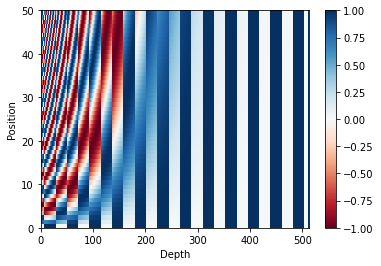

In [19]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu') #컬러 : Red&Blue
plt.xlabel('Depth')
plt.xlim((0, 512)) # d_model의 차원=512
plt.ylabel('Position')
plt.colorbar() # 칼라바(우측) 표시
plt.show()

## 어텐션

In [20]:
def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
    output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)  

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

    return output, attention_weights

## 멀티헤드어텐션

In [21]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = kargs['num_heads']
        self.d_model = kargs['d_model']

        assert self.d_model % self.num_heads == 0

        self.depth = self.d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(kargs['d_model'])
        self.wk = tf.keras.layers.Dense(kargs['d_model'])
        self.wv = tf.keras.layers.Dense(kargs['d_model'])

        self.dense = tf.keras.layers.Dense(kargs['d_model'])

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

        concat_attention = tf.reshape(scaled_attention, 
                                      (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

        return output, attention_weights

## Point_wise_feed_forward_network

In [22]:
def point_wise_feed_forward_network(**kargs):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(kargs['dff'], activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(kargs['d_model'])  # (batch_size, seq_len, d_model)
    ])

## 인코더 레이어

In [23]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(**kargs)
        self.ffn = point_wise_feed_forward_network(**kargs)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, mask):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

## 디코더 레이어

In [24]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(**kargs)
        self.mha2 = MultiHeadAttention(**kargs)

        self.ffn = point_wise_feed_forward_network(**kargs)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout2 = tf.keras.layers.Dropout(kargs['rate'])
        self.dropout3 = tf.keras.layers.Dropout(kargs['rate'])
    
    
    def call(self, x, enc_output, look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

## 인코더

In [25]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(Encoder, self).__init__()

        self.d_model = kargs['d_model']
        self.num_layers = kargs['num_layers']

        self.embedding = tf.keras.layers.Embedding(kargs['input_vocab_size'], self.d_model)
        self.pos_encoding = positional_encoding(kargs['maximum_position_encoding'], 
                                                self.d_model)


        self.enc_layers = [EncoderLayer(**kargs) 
                           for _ in range(self.num_layers)]

        self.dropout = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, mask):

        seq_len = tf.shape(x)[1]

        # adding embedding and position encoding.
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, mask)

        return x  # (batch_size, input_seq_len, d_model)

## 디코더

In [26]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, **kargs):
        super(Decoder, self).__init__()

        self.d_model = kargs['d_model']
        self.num_layers = kargs['num_layers']

        self.embedding = tf.keras.layers.Embedding(kargs['target_vocab_size'], self.d_model)
        self.pos_encoding = positional_encoding(kargs['maximum_position_encoding'], self.d_model)

        self.dec_layers = [DecoderLayer(**kargs) 
                           for _ in range(self.num_layers)]
        self.dropout = tf.keras.layers.Dropout(kargs['rate'])

    def call(self, x, enc_output, look_ahead_mask, padding_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights

## 트랜스포머 모델

In [27]:
class Transformer(tf.keras.Model):
    def __init__(self, **kargs):
        super(Transformer, self).__init__(name=kargs['model_name'])
        self.end_token_idx = kargs['end_token_idx']
        
        self.encoder = Encoder(**kargs)
        self.decoder = Decoder(**kargs)

        self.final_layer = tf.keras.layers.Dense(kargs['target_vocab_size'])

    def call(self, x):
        inp, tar = x

        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)
        enc_output = self.encoder(inp, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, _ = self.decoder(
            tar, enc_output, look_ahead_mask, dec_padding_mask)

        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

        return final_output
    
    def inference(self, x):
        inp = x
        tar = tf.expand_dims([STD_INDEX], 0)

        enc_padding_mask, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)        
        enc_output = self.encoder(inp, enc_padding_mask)
        
        predict_tokens = list()
        for t in range(0, MAX_SEQUENCE):
            dec_output, _ = self.decoder(tar, enc_output, look_ahead_mask, dec_padding_mask)
            final_output = self.final_layer(dec_output)
            outputs = tf.argmax(final_output, -1).numpy()
            pred_token = outputs[0][-1]
            if pred_token == self.end_token_idx:
                break
            predict_tokens.append(pred_token)
            tar = tf.expand_dims([STD_INDEX] + predict_tokens, 0)
            _, look_ahead_mask, dec_padding_mask = create_masks(inp, tar)
            
        return predict_tokens

## 모델 로스 설정

In [28]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')

def loss(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

def accuracy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask    
    acc = train_accuracy(real, pred)

    return tf.reduce_mean(acc)

## 모델 컴파일

In [29]:
model = Transformer(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=loss,
              metrics=[accuracy])

## Callback ( earlystop )

In [30]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

./data_out/transformer -- Folder create complete 



## 모델 학습

In [40]:
history = model.fit([index_inputs, index_outputs], index_targets, 
                    batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/30
5318/5320 [============================>.] - ETA: 0s - loss: 0.3797 - accuracy: 0.8848
Epoch 1: val_accuracy improved from 0.88362 to 0.88579, saving model to ./data_out/transformer/weights.h5
5320/5320 [==============================] - 126s 24ms/step - loss: 0.3797 - accuracy: 0.8848 - val_loss: 1.8355 - val_accuracy: 0.8858
Epoch 2/30
5319/5320 [============================>.] - ETA: 0s - loss: 0.3759 - accuracy: 0.8868
Epoch 2: val_accuracy improved from 0.88579 to 0.88774, saving model to ./data_out/transformer/weights.h5
5320/5320 [==============================] - 126s 24ms/step - loss: 0.3759 - accuracy: 0.8868 - val_loss: 1.7836 - val_accuracy: 0.8877
Epoch 3/30
5319/5320 [============================>.] - ETA: 0s - loss: 0.3694 - accuracy: 0.8887
Epoch 3: val_accuracy improved from 0.88774 to 0.88954, saving model to ./data_out/transformer/weights.h5
5320/5320 [==============================] - 126s 24ms/step - loss: 0.3693 - accuracy: 0.8887 - val_loss: 1.8055 - v

## 성능 그래프

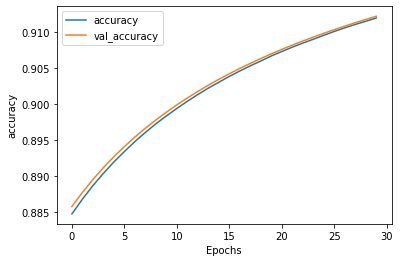

In [41]:
plot_graphs(history, 'accuracy')

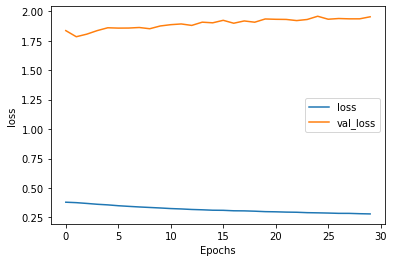

In [42]:
plot_graphs(history, 'loss')

## 최고성능모델 불러오기

In [43]:
DATA_OUT_PATH = './data_out/'
SAVE_FILE_NM = 'weights.h5'

model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

## 모델 테스트

In [44]:
char2idx = prepro_configs['char2idx']
idx2char = prepro_configs['idx2char']

In [45]:
text = "안녕?"
test_index_inputs, _ = enc_processing([text], char2idx)
outputs = model.inference(test_index_inputs)

print(' '.join([idx2char[str(o)] for o in outputs]))

안녕하세요


In [57]:
text = "받고 싶은 선물 있니?"
test_index_inputs, _ = enc_processing([text], char2idx)
outputs = model.inference(test_index_inputs)

print(' '.join([idx2char[str(o)] for o in outputs]))

저 도 좋아해주세요


In [ ]:
text = "받고 싶은 선물 있니?"
test_index_inputs, _ = enc_processing([text], char2idx)
outputs = model.inference(test_index_inputs)

print(' '.join([idx2char[str(o)] for o in outputs]))

In [58]:
text = "내일 뭐하지?"
test_index_inputs, _ = enc_processing([text], char2idx)
outputs = model.inference(test_index_inputs)

print(' '.join([idx2char[str(o)] for o in outputs]))

지 금도 잘 하고있어요


# TEST

### mask

In [ ]:
import tensorflow as tf

In [ ]:
b=1-tf.linalg.band_part(tf.ones((2,2)),-1,0)

In [ ]:
b*-1e9

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[-0.e+00, -1.e+09],
       [-0.e+00, -0.e+00]], dtype=float32)>

In [ ]:
import numpy as np

In [ ]:
a=np.array([[1,2],[3,4]])

In [ ]:
a+=b*-1e9

In [ ]:
a

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 1.e+00, -1.e+09],
       [ 3.e+00,  4.e+00]], dtype=float32)>

### tf.matamul

In [ ]:
a=np.array([[[[1,2,3],[3,4,5]],[[5,6,7],[7,8,9]]],[[[1,2,3],[3,4,5]],[[5,6,7],[7,8,9]]]])

In [ ]:
a.shape

(2, 2, 2, 3)

In [ ]:
tf.matmul(a,a,transpose_b=True)

<tf.Tensor: shape=(2, 2, 2, 2), dtype=int64, numpy=
array([[[[ 14,  26],
         [ 26,  50]],

        [[110, 146],
         [146, 194]]],


       [[[ 14,  26],
         [ 26,  50]],

        [[110, 146],
         [146, 194]]]])>

### tf.reshape & tf.transpose  (4차원)

In [ ]:
a = np.array([[[1,2,3,4],[4,5,6,7]],[[7,8,9,10],[10,11,12,13]]])
a

array([[[ 1,  2,  3,  4],
        [ 4,  5,  6,  7]],

       [[ 7,  8,  9, 10],
        [10, 11, 12, 13]]])

In [ ]:
b=tf.reshape(a,(2,-1,2,2))
b

<tf.Tensor: shape=(2, 2, 2, 2), dtype=int64, numpy=
array([[[[ 1,  2],
         [ 3,  4]],

        [[ 4,  5],
         [ 6,  7]]],


       [[[ 7,  8],
         [ 9, 10]],

        [[10, 11],
         [12, 13]]]])>

In [ ]:
tf.transpose(b) # perm = [3,2,1,0]

<tf.Tensor: shape=(2, 2, 2, 2), dtype=int64, numpy=
array([[[[ 1,  7],
         [ 4, 10]],

        [[ 3,  9],
         [ 6, 12]]],


       [[[ 2,  8],
         [ 5, 11]],

        [[ 4, 10],
         [ 7, 13]]]])>

In [ ]:
tf.transpose(b,[0,2,1,3])

<tf.Tensor: shape=(2, 2, 2, 2), dtype=int64, numpy=
array([[[[ 1,  2],
         [ 4,  5]],

        [[ 3,  4],
         [ 6,  7]]],


       [[[ 7,  8],
         [10, 11]],

        [[ 9, 10],
         [12, 13]]]])>

In [ ]:
tf.transpose(b,[3,1,2,0])

<tf.Tensor: shape=(2, 2, 2, 2), dtype=int64, numpy=
array([[[[ 1,  7],
         [ 3,  9]],

        [[ 4, 10],
         [ 6, 12]]],


       [[[ 2,  8],
         [ 4, 10]],

        [[ 5, 11],
         [ 7, 13]]]])>

In [ ]:
tf.reshape(a,(2,2,-1,2))

<tf.Tensor: shape=(2, 2, 2, 2), dtype=int64, numpy=
array([[[[ 1,  2],
         [ 3,  4]],

        [[ 4,  5],
         [ 6,  7]]],


       [[[ 7,  8],
         [ 9, 10]],

        [[10, 11],
         [12, 13]]]])>

In [ ]:
x = tf.constant([[[ 1,  2,  3],
                  [ 4,  5,  6]],
                 [[ 7,  8,  9],
                  [10, 11, 12]]])

In [ ]:
x

<tf.Tensor: shape=(2, 2, 3), dtype=int32, numpy=
array([[[ 1,  2,  3],
        [ 4,  5,  6]],

       [[ 7,  8,  9],
        [10, 11, 12]]], dtype=int32)>

In [ ]:
tf.transpose(x) #perm=[2,1,0]

<tf.Tensor: shape=(3, 2, 2), dtype=int32, numpy=
array([[[ 1,  7],
        [ 4, 10]],

       [[ 2,  8],
        [ 5, 11]],

       [[ 3,  9],
        [ 6, 12]]], dtype=int32)>

In [ ]:
tf.transpose(x,perm=[1,2,0])

<tf.Tensor: shape=(2, 3, 2), dtype=int32, numpy=
array([[[ 1,  7],
        [ 2,  8],
        [ 3,  9]],

       [[ 4, 10],
        [ 5, 11],
        [ 6, 12]]], dtype=int32)>

In [ ]:
tf.transpose(x,perm=[2,0,1])

<tf.Tensor: shape=(3, 2, 2), dtype=int32, numpy=
array([[[ 1,  4],
        [ 7, 10]],

       [[ 2,  5],
        [ 8, 11]],

       [[ 3,  6],
        [ 9, 12]]], dtype=int32)>

In [ ]:
a=np.array([[1,2,3],[4,5,6]])
a

array([[1, 2, 3],
       [4, 5, 6]])

In [ ]:
tf.transpose(a) # perm = [1,0]

<tf.Tensor: shape=(3, 2), dtype=int64, numpy=
array([[1, 4],
       [2, 5],
       [3, 6]])>

perm의 해당 차원(axis)에 따른 연산 횟수(이어붙이기)가, 새로 만들어지는 행렬의 행 차원이 될 것이므로, 현재 차원이 perm의 위치에 따라 적절하게 변하다.

perm의 마지막 axis부터 차례대로 뒷 차원부터 쌓여서 결과가 나올텐데,
각 차원에 해당하는 이어붙이기 개수가 그 차워의 개수가 될 것이므로,\
차원이 우리가 원하는 대로 변형된다.

### list의 [...]

In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
a=np.array([[1,2,3],[4,5,6]])
a

array([[1, 2, 3],
       [4, 5, 6]])

In [ ]:
a[...]

array([[1, 2, 3],
       [4, 5, 6]])

In [ ]:
a[np.newaxis,...]

array([[[1, 2, 3],
        [4, 5, 6]]])

In [ ]:
a[...,np.newaxis]

array([[[1],
        [2],
        [3]],

       [[4],
        [5],
        [6]]])

### BroadCastiing numpy

In [ ]:
import numpy as np
import tensorflow as tf

In [ ]:
a=np.array([[[1,2,3],[4,5,6]]]) 
print(a.shape)
b=np.array([[[1,2,3],[4,5,6]],[[7,8,9],[10,11,12]]]) 
print(b.shape)
b+a

(1, 2, 3)
(2, 2, 3)


array([[[ 2,  4,  6],
        [ 8, 10, 12]],

       [[ 8, 10, 12],
        [14, 16, 18]]])

In [ ]:
a=tf.cast(np.array([[False,True,True],[False,False,True]]),tf.float32) # 2 x 3 ( 문장 개수 x 단어 개수 )
c=a[:,None,None,:] # 2 x 1 x 1 x 3  ( 문장 개수 x 1 x 1 x 단어 개수)

In [ ]:
c

<tf.Tensor: shape=(2, 1, 1, 3), dtype=float32, numpy=
array([[[[0., 1., 1.]]],


       [[[0., 0., 1.]]]], dtype=float32)>

In [ ]:
b=np.array([[0,1,1],[0,0,1],[0,0,0]])  # 3 x 3  ( 단어 개수 x 단어 개수 )
print(b)
tf.maximum(c,b)

[[0 1 1]
 [0 0 1]
 [0 0 0]]


<tf.Tensor: shape=(2, 1, 3, 3), dtype=float32, numpy=
array([[[[0., 1., 1.],
         [0., 1., 1.],
         [0., 1., 1.]]],


       [[[0., 1., 1.],
         [0., 0., 1.],
         [0., 0., 1.]]]], dtype=float32)>

In [ ]:
a=np.array([[[[1,2,3],[4,5,6],[7,8,9]],[[7,8,9],[10,11,12],[1,2,3]]],[[[1,2,3],[4,5,6],[7,8,9]],[[7,8,9],[10,11,12],[1,2,3]]]])

In [ ]:
print(a.shape)
a

(2, 2, 3, 3)


array([[[[ 1,  2,  3],
         [ 4,  5,  6],
         [ 7,  8,  9]],

        [[ 7,  8,  9],
         [10, 11, 12],
         [ 1,  2,  3]]],


       [[[ 1,  2,  3],
         [ 4,  5,  6],
         [ 7,  8,  9]],

        [[ 7,  8,  9],
         [10, 11, 12],
         [ 1,  2,  3]]]])

In [ ]:
mask=np.array([[[[0,0,-100]]],[[[0,-100,-100]]]])
print(mask.shape)
mask

(2, 1, 1, 3)


array([[[[   0,    0, -100]]],


       [[[   0, -100, -100]]]])

In [ ]:
a+mask

array([[[[  1,   2, -97],
         [  4,   5, -94],
         [  7,   8, -91]],

        [[  7,   8, -91],
         [ 10,  11, -88],
         [  1,   2, -97]]],


       [[[  1, -98, -97],
         [  4, -95, -94],
         [  7, -92, -91]],

        [[  7, -92, -91],
         [ 10, -89, -88],
         [  1, -98, -97]]]])

In [ ]:
True*-100

-100

### tf.linalg.band_part( , -1, 0)

In [ ]:
import tensorflow as tf
import numpy as np

In [ ]:
tf.linalg.band_part(tf.ones((5, 5)), 0, 0)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)>

In [ ]:
tf.linalg.band_part(tf.ones((5, 5)), -1, 0)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[1., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0.],
       [1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1.]], dtype=float32)>

In [ ]:
1-tf.linalg.band_part(tf.ones((5, 5)), -1, 0)

<tf.Tensor: shape=(5, 5), dtype=float32, numpy=
array([[0., 1., 1., 1., 1.],
       [0., 0., 1., 1., 1.],
       [0., 0., 0., 1., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0.]], dtype=float32)>